# Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal, gaussian_kde, dirichlet, wishart, t
from scipy.integrate import quad, nquad
from scipy.special import gammaln, psi, digamma, gamma
from scipy.linalg import det, inv
from sklearn.model_selection import train_test_split

# Генерируем сам датасет

In [11]:
# Параметры
n_points = 500         # Количество точек
dim = 2                # Размерность (для двумерных данных)

# Матрица переходов A (произвольная, стабильная)
A = np.array([
    [0.6, 0.2],
    [0.1, 0.7]
])

# Ковариационная матрица шума
Sigma = np.array([
    [1.0, 0.3],
    [0.3, 1.0]
])

# Инициализация начального вектора y_0
np.random.seed(42)  # Для воспроизводимости
y_prev = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))

# Генерация временного ряда
data = []
for t in range(n_points):
    error = np.random.multivariate_normal(mean=np.zeros(dim), cov=Sigma)
    y_t = A @ y_prev + error
    data.append(y_t)
    y_prev = y_t

# Преобразуем в массив и DataFrame
data_array = np.array(data)
df = pd.DataFrame(data_array, columns=['x1', 'x2'])

# Сохраняем в CSV (если нужно)
df.to_csv('synthetic_var_dataset.csv', index=False)

print("Первые 5 строк датасета:")
print(df.head())

Первые 5 строк датасета:
         x1        x2
0 -1.152844  0.331740
1 -0.298061  0.167197
2 -1.872620 -0.731950
3 -1.212442 -0.000142
4 -0.078345 -0.023254


## Визуализация

### Временные ряды

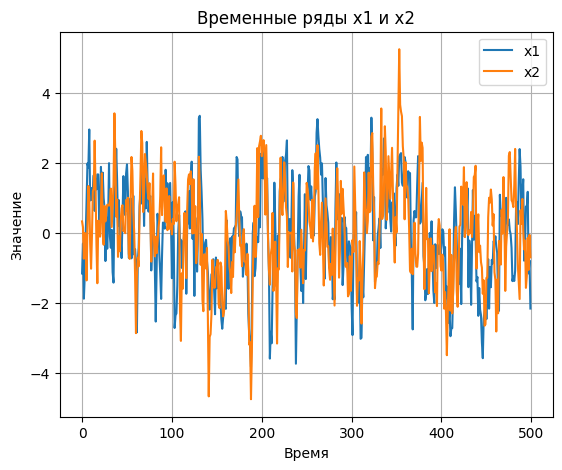

In [12]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(df['x1'], label='x1')
plt.plot(df['x2'], label='x2')
plt.title('Временные ряды x1 и x2')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

### Фазовый портрет (x1 vs x2)

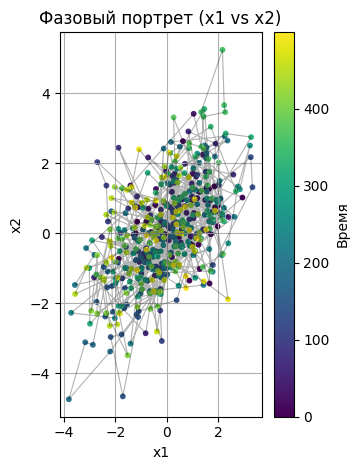

In [13]:
plt.subplot(1, 2, 2)
plt.scatter(df['x1'], df['x2'], c=range(n_points), cmap='viridis', s=10)
plt.plot(df['x1'], df['x2'], 'k-', alpha=0.3, linewidth=0.8)
plt.colorbar(label='Время')
plt.title('Фазовый портрет (x1 vs x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

plt.tight_layout()
plt.show()

# GMR

## GMM